In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.linear_model import LinearRegression

import os


os.environ['NIXTLA_ID_AS_COL'] = '1'
plt.rcParams['axes.grid'] = True

### STL Decomposition

STL takes the observed series and explained it as:
And it answes:
 - Is there a trend?
 - Is there seasonality?
 - What's left after removing both?

`y = T + S + R`

`Trend`: T_t\
`Seasonal`: S_t\
`Remainder`: R_t

<br>

Decide Whether:
 - Differencing is needed
 - Seasonality exists
 - ETS vs ARIMA make sense

In [68]:
np.random.seed(555)

n = 200
t = np.arange(n)

trend = 0.05 * t + 0.002 * t**1.3
seasonal = 2 * np.sin(2 * np.pi * t / 20)
noise = np.random.normal(0, 0.8, size=n)

y = trend + seasonal + noise

ts = pd.Series(y, index=pd.date_range("2020-01-01", periods=n))

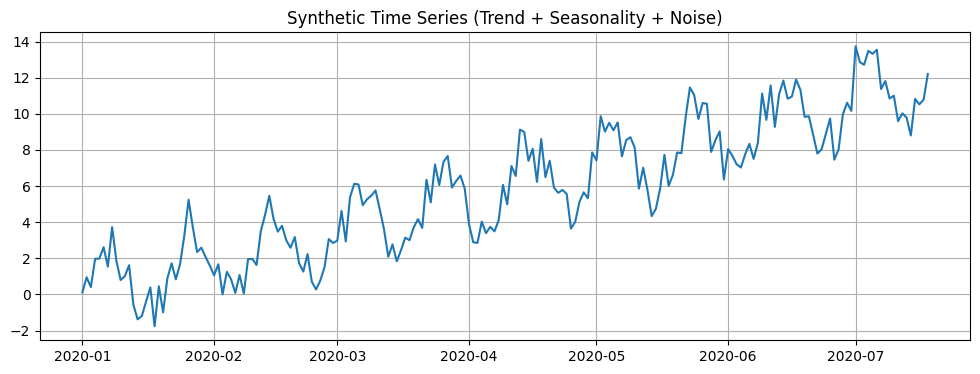

In [69]:
plt.figure(figsize=(12, 4))
plt.plot(ts)
plt.title("Synthetic Time Series (Trend + Seasonality + Noise)")
plt.show()

- upward drift (Trend)
- repeating pattern (Seasonality)
- Small randomess (Noise)

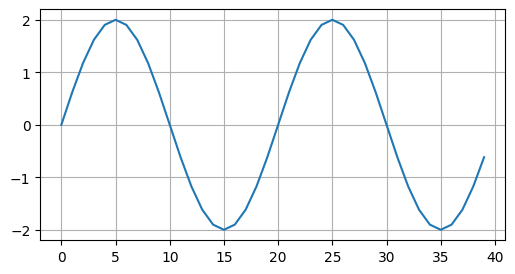

In [70]:
# One full wave every 20 points
plt.figure(figsize=(6, 3))
plt.plot(seasonal[:40])
plt.show()

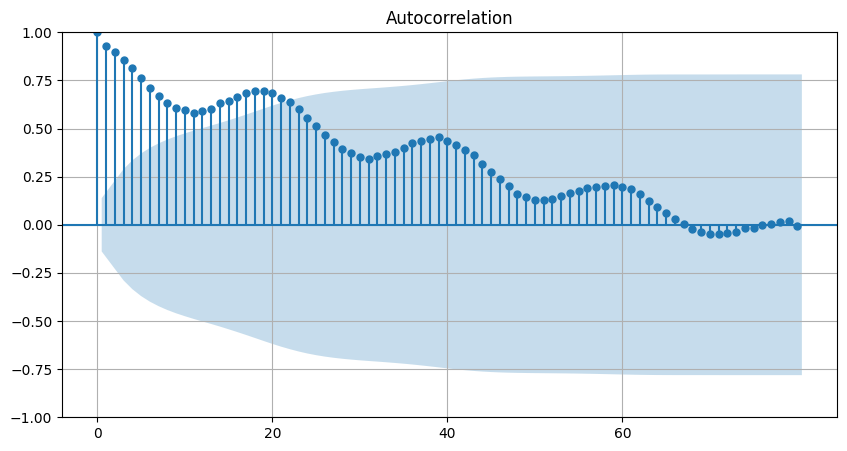

In [71]:
plt.rc("figure", figsize=(10,5))
plot_acf(ts, lags=80)
plt.xticks(range(0, 79, 20))
plt.show()

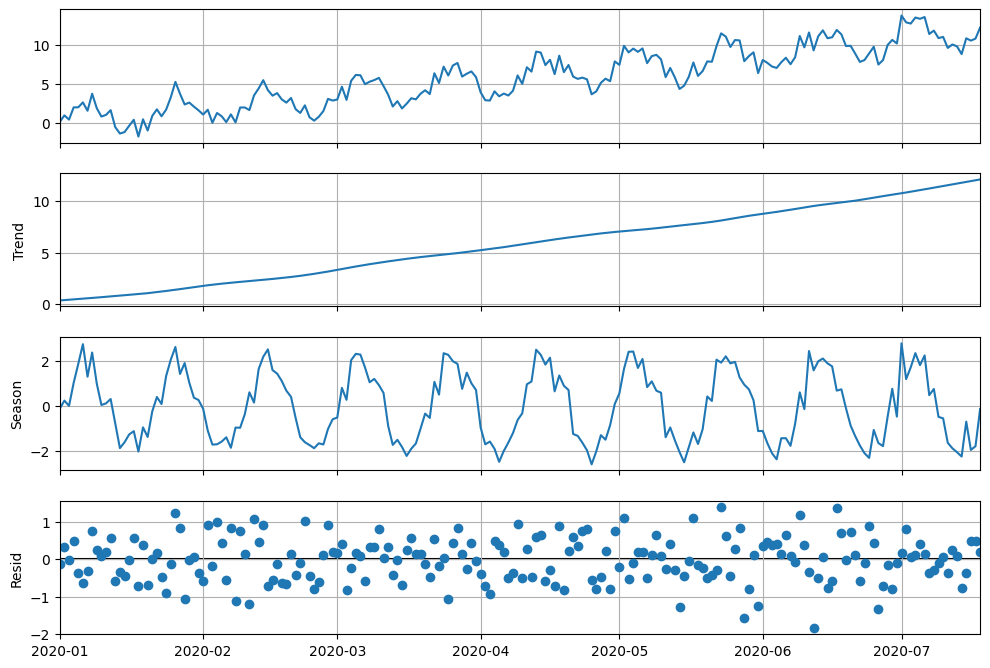

In [72]:
# period=20  |  the seasonal pattern repeats every 20 steps
period = 20
res = STL(ts, period=period).fit()

f = res.plot()
f.set_figwidth(10)
f.set_figheight(7)

#Residual Analysis with ACF

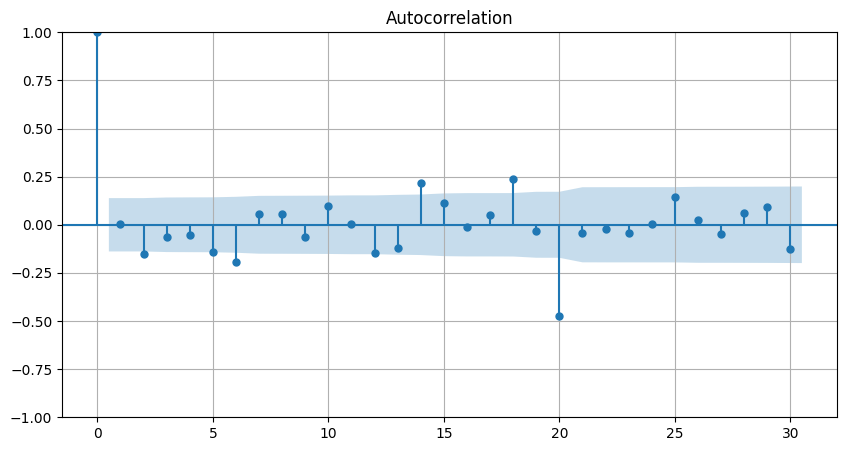

In [73]:
residual_component = res.resid

plot_acf(residual_component.dropna(), lags=30)
plt.show()

- close to white noise seems ok

### Forecasting

`STL`: y_t = T_t + S_t + R_t\
`Forecast`: y_t+h = T_t+h + S_t+h + R_t+h


`Trend` -> extrapolate\
`Seasonality` -> repeat the learned seasonal pattern\
`Remainder` -> model or assume zero

In [74]:
# since residuals are very close to white noise i will assume zero
trend = res.trend
seasonality = res.seasonal
residual = res.resid

In [75]:
# forecast horizon
# another wave
h = 20

In [76]:
X = np.arange(len(trend)).reshape(-1, 1)
y = trend.values

# Simple Linear Regression Extrapolation
model = LinearRegression().fit(X, y)

X_future = np.arange(len(trend), len(trend) + h).reshape(-1, 1)
trend_f = model.predict(X_future)

In [77]:
# simply take the last seasonal pattern
seasonal_pattern = seasonality[-period:].values
seasonal_f = np.tile(seasonal_pattern, h // period + 1)[:h]

In [78]:
# without residuals
resid_f_zero = np.zeros(h)

forecast_no_resid = trend_f + seasonal_f + resid_f_zero

In [79]:
forecast_no_resid

array([12.51104592, 11.34090966, 14.63861284, 13.11690582, 13.69808479,
       14.38325053, 13.91108711, 14.39916681, 12.70365426, 13.03588701,
       11.86329603, 11.85542087, 10.83499357, 10.65149849, 10.53780895,
       10.40539225, 12.00597478, 10.81626636, 11.03919994, 12.74300553])

In [80]:
resid_model = ARIMA(residual, order=(1,0,0)).fit()
resid_f_ar = resid_model.forecast(h)

forecast_with_resid = trend_f + seasonal_f + resid_f_ar

In [81]:
forecast_with_resid

2020-07-19    12.505545
2020-07-20    11.334686
2020-07-21    14.632386
2020-07-22    13.110679
2020-07-23    13.691858
2020-07-24    14.377024
2020-07-25    13.904861
2020-07-26    14.392940
2020-07-27    12.697428
2020-07-28    13.029660
2020-07-29    11.857069
2020-07-30    11.849194
2020-07-31    10.828767
2020-08-01    10.645272
2020-08-02    10.531582
2020-08-03    10.399166
2020-08-04    11.999748
2020-08-05    10.810040
2020-08-06    11.032973
2020-08-07    12.736779
Freq: D, Name: predicted_mean, dtype: float64

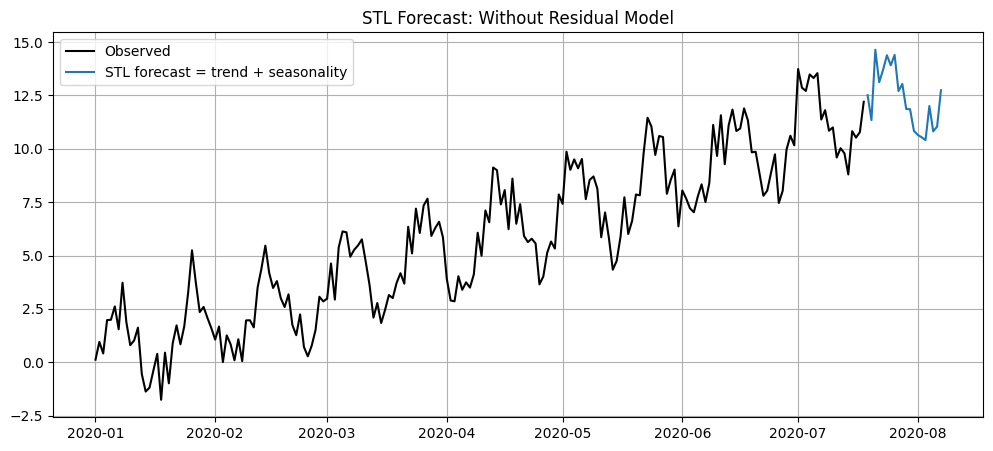

In [82]:
plt.figure(figsize=(12,5))

plt.plot(ts, label="Observed", color="black")
plt.plot(ts.index[-1] + pd.to_timedelta(np.arange(1, h+1), "D"),
         forecast_no_resid, label="STL forecast = trend + seasonality", linestyle="-")

plt.legend()
plt.title("STL Forecast: Without Residual Model")
plt.show()


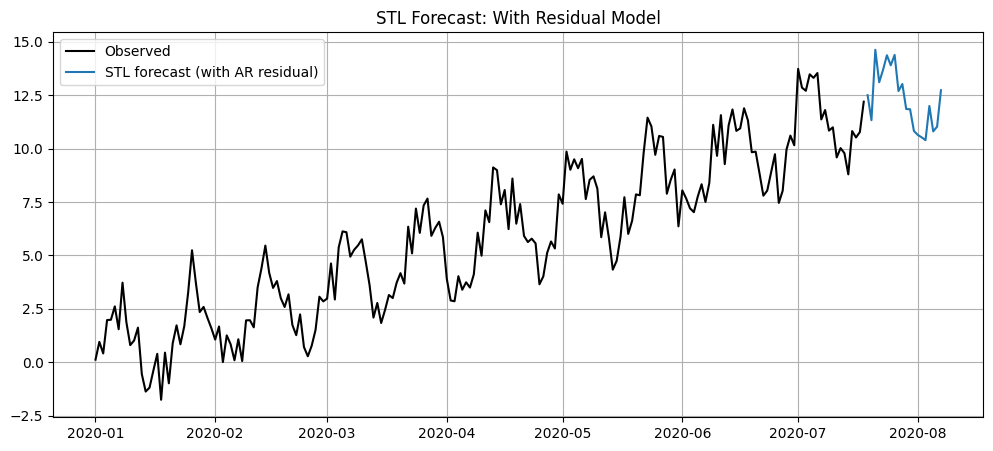

In [83]:
plt.figure(figsize=(12,5))

plt.plot(ts, label="Observed", color="black")
plt.plot(ts.index[-1] + pd.to_timedelta(np.arange(1, h+1), "D"),
         forecast_with_resid, label="STL forecast (with AR residual)", linestyle="-")

plt.legend()
plt.title("STL Forecast: With Residual Model")
plt.show()